>**Load the libraries, mount drive and load data**

In [1]:
!pip install kmodes
!pip install xgboost
!pip install lightgbm
!pip install mlxtend
!pip install Boruta
%pip install mlxtend --upgrade
#################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns
import statsmodels.api as sm
import os
import warnings
from kmodes.kmodes import KModes
from pandas_profiling import ProfileReport
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from scipy.stats.stats import kendalltau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression #linear_model.LogisticRegression (setting multi_class=”multinomial”)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import lightgbm as lgbm
from sklearn.datasets import make_blobs
import scipy.stats as stats
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
%matplotlib inline
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.9 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


> **DATA PREPROCESSING**

In [95]:
non_genetic_data=pd.read_csv("/content/drive/MyDrive/d2k/tarrc_nongenomic.csv")

In [3]:
pd.set_option('display.max_rows', None)

In [96]:
non_genetic_data.head(5)

,STUDYID,PATID,VISIT,MISC_TARC_PAT_VISIT,CCR,CCR_YES,CCR_CL_IMPRESS_CODE,CCR_MCIAMEM,CCR_MCIAPLUS,CCR_MCIAPLAN,...,P1_PTTYPEDESC,P1_SERUM,P1_SHARE_AGREE,P1_SHARE_DATEX,P1_TIMEDRAWX,P1_TIMEFOODX,P1_TIMESTICKX,P1_WHOLEBLOOD,P1_WHYNOTALL,P1_WHYNOTALLX
0,1119,11001119,1,1100111901,0,,,,,,...,AD,0,0,,,,,1,0,
1,1221,11001221,1,1100122101,0,,,,,,...,AD,1,0,,,,,1,0,
2,1221,11001221,2,1100122102,0,,,,,,...,AD,1,0,,16:50:00,,,1,0,
3,1221,11001221,3,1100122103,0,,,,,,...,AD,0,0,,,,,0,0,
4,1221,11001221,4,1100122104,0,,,,,,...,AD,0,0,,,,,0,0,


> **DATA CLEANING FUNCTION BLOCK**

In [99]:
def preprocessing(non_genetic_data):

  #Only retain the data where the patients' samples are analysed with RBM 
  df_with_RBM = non_genetic_data[non_genetic_data['RBM_Rule_Based_Medicine']==1]

  #Drop columns which are not "biomarkers"
  df_biomarkers = df_with_RBM.drop(['STUDYID','PATID','VISIT','MISC_TARC_PAT_VISIT','CCR','CCR_YES','CCR_CL_IMPRESS_CODE',
 'CCR_MCIAMEM','CCR_MCIAPLUS','CCR_MCIAPLAN','CCR_MCIAPATT','CCR_MCIAPEX','CCR_MCIAPVIS','CCR_MCINON1','CCR_MCIN1LAN',
 'CCR_MCIN1ATT','CCR_MCIN1EX','CCR_MCIN1VIS','CCR_MCINON2','CCR_MCIN2LAN','CCR_MCIN2ATT','CCR_MCIN2EX','CCR_MCIN2VIS',
 'CCR_YES_NOTES','MISC_SITEID','A1_BIRTHYR','A1_EVENTDATEX','A1_HANDEDNESS','A1_HISPANIC','A1_HISPANIC_TYPE','A1_HISPORX',
 'A1_MARISTAT','A1_RACE','A1_RACESEC','A41_PMA','A41_PMAF','A41_PMAFU','A41_PMAP','A41_PMAPF','A41_PMAPFU','A41_PMAPREV',
 'A41_PMART','A41_PMAS','A41_PMASTDA','A41_PMASTMO','A41_PMASTYR','A41_PMASU','A41_PMB','A41_PMBF','A41_PMBFU','A41_PMBP',
 'A41_PMBPF','A41_PMBPFU','A41_PMBPREV','A41_PMBRT','A41_PMBS','A41_PMBSTDA','A41_PMBSTMO','A41_PMBSTYR','A41_PMBSU',
 'A42_VEA','A42_VEAF','A42_VEAFU','A42_VEAPREV','A42_VEART','A42_VEAS','A42_VEASU','A43_ADA','A43_ADACONT','A43_ADAENDDA',
 'A43_ADAENDMO','A43_ADAENDYR','A43_ADAF','A43_ADAFU','A43_ADAPREV','A43_ADART','A43_ADAS','A43_ADASTDA','A43_ADASTMO','A43_ADASTYR',
 'A43_ADASU','A43_ADB','A43_ADBCONT','A43_ADBENDDA','A43_ADBENDMO','A43_ADBENDYR','A43_ADBF','A43_ADBFU','A43_ADBPREV','A43_ADBRT',
 'A43_ADBS','A43_ADBSTDA','A43_ADBSTMO','A43_ADBSTYR','A43_ADBSU','A43_ADC','A43_ADCCONT','A43_ADCENDDA','A43_ADCENDMO','A43_ADCENDYR',
 'A43_ADCF', 'A43_ADCFU', 'A43_ADCPREV', 'A43_ADCRT', 'A43_ADCS', 'A43_ADCSTDA', 'A43_ADCSTMO',
 'A43_ADCSTYR','A43_ADCSU','A43_ADD','A43_ADDCONT','A43_ADDENDDA','A43_ADDENDMO','A43_ADDENDYR','A43_ADDF','A43_ADDFU','A43_ADDPREV','A43_ADDRT',
 'A43_ADDS','A43_ADDSTDA','A43_ADDSTMO','A43_ADDSTYR','A43_ADDSU','A43_ADE','A43_ADECONT','A43_ADEENDDA','A43_ADEENDMO','A43_ADEENDYR',
 'A43_ADEF','A43_ADEFU','A43_ADEPREV','A43_ADERT','A43_ADES','A43_ADESTDA','A43_ADESTMO','A43_ADESTYR','A43_ADESU','A43_ADF','A43_ADFCONT',
 'A43_ADFENDDA','A43_ADFENDMO','A43_ADFENDYR','A43_ADFF','A43_ADFFU','A43_ADFPREV','A43_ADFRT','A43_ADFS','A43_ADFSTDA','A43_ADFSTMO','A43_ADFSTYR',
 'A43_ADFSU','A43_ADMEDEVER','A44_DRG_TRIAL','A44_DRG_TRIALX','A44_SSA','A44_SSAF','A44_SSAFU','A44_SSAPREV','A44_SSART','A44_SSAS','A44_SSASTDA',
 'A44_SSASTMO','A44_SSASTYR','A44_SSASU','A44_SSB','A44_SSBF','A44_SSBFU','A44_SSBPREV','A44_SSBRT','A44_SSBS','A44_SSBSTDA','A44_SSBSTMO',
 'A44_SSBSTYR','A44_SSBSU','A44_SSC','A44_SSCF','A44_SSCFU','A44_SSCPREV','A44_SSCRT','A44_SSCS','A44_SSCSTDA','A44_SSCSTMO','A44_SSCSTYR',
 'A44_SSCSU','A44_SSD','A44_SSDF','A44_SSDFU','A44_SSDPREV','A44_SSDRT','A44_SSDS','A44_SSDSTDA','A44_SSDSTMO','A44_SSDSTYR','A44_SSDSU',
 'A44_SSE','A44_SSEF','A44_SSEFU','A44_SSEPREV','A44_SSERT','A44_SSES','A44_SSESTDA','A44_SSESTMO','A44_SSESTYR','A44_SSESU','A44_SSF',
 'A44_SSFF','A44_SSFFU','A44_SSFPREV','A44_SSFRT','A44_SSFS','A44_SSFSTDA','A44_SSFSTMO','A44_SSFSTYR','A44_SSFSU','A5_ABUSOTHR','A5_ABUSX',
 'A5_ALCOHOL','A5_ARTHRITIC','A5_AUTOIMM','A5_B12DEF','A5_CANCER','A5_CBOTHR','A5_CBOTHRX','A5_CBSTROKE','A5_CBTIA','A5_CHRON_OTH','A5_CHRON_OTHX',
 'A5_CVAFIB', 'A5_CVANGIO','A5_CVBYPASS','A5_CVCHF','A5_CVHATT','A5_CVOTHR','A5_CVOTHRX','A5_CVPACE','A5_DEP2YRS','A5_DEPOTHR','A5_DIABETES',
 'A5_HYPERCHO','A5_HYPERTEN','A5_IBD','A5_INCONTF','A5_INCONTU','A5_NCOTHR','A5_NCOTHRX','A5_PACKSPER','A5_PD','A5_PDOTHR','A5_PDOTHRYR',
 'A5_PDYR','A5_PSYCDIS','A5_PSYCDISX','A5_QUITSMOK','A5_SEIZURES','A5_SMOKYRS','A5_STROK1YR','A5_STROK2YR','A5_STROK3YR','A5_STROK4YR',
 'A5_STROK5YR','A5_STROK6YR','A5_THYROID','A5_TIA1YR','A5_TIA2YR','A5_TIA3YR','A5_TIA4YR','A5_TIA5YR','A5_TIA6YR','A5_TOBAC100','A5_TOBAC30',
 'A5_TOBACLSTYR','A5_TRAUMBRF','A5_TRAUMCHR','A5_TRAUMEXT','B1_HEARAID','B1_HEARING','B1_HEARWAID','B1_HEIGHT','B1_HRATE','B1_VISCORR','B1_VISION',
 'B1_VISWCORR','B1_WEIGHT','B5_NPIQINF','B5_NPIQINFX','B5_DEL','B5_DELSEV','B5_HALL','B5_HALLSEV','B5_AGIT','B5_AGITSEV','B5_DEPD','B5_DEPDSEV',
 'B5_ANX','B5_ANXSEV','B5_ELAT','B5_ELATSEV','B5_APA','B5_APASEV','B5_DISN','B5_DISNSEV','B5_IRR','B5_IRRSEV','B5_MOT','B5_MOTSEV','B5_NITE',
 'B5_NITESEV','B5_APP','B5_APPSEV','C1_ANIMAL','C1_BOSTON30','C1_BOSTON60','C1_DATEX','C1_CDRCA','C1_CDRGLOB','C1_CDRHOB','C1_CDRJU','C1_CDRMEM',
 'C1_CDROR','C1_CDRPER','C1_CDRSUM', 'C1_CERAD_LL_1', 'C1_CERAD_LL_2', 'C1_CERAD_LL_3', 'C1_CERAD_LL_DELAY', 'C1_CERAD_LL_TOT', 'C1_CERAD_WR_DISCRIM',
 'C1_CERAD_WR_NO', 'C1_CERAD_WR_YES', 'C1_CLOCK', 'C1_CLOX1', 'C1_CLOX2', 'C1_FAS_A', 'C1_FAS_F', 'C1_FAS_S', 'C1_GDS15', 'C1_GDS30', 'C1_LITPROB',
 'C1_MMSE', 'C1_SS_AMNART', 'C1_SS_BOSTON60', 'C1_SS_COMBINED_DIGTOT', 'C1_SS_COMBINED_LM_I', 'C1_SS_COMBINED_LM_II', 'C1_SS_COMBINED_VR_I',
 'C1_SS_COMBINED_VR_II', 'C1_SS_COWAT', 'C1_SS_TRAILA', 'C1_SS_TRAILB', 'C1_SS_WAIS3_DIGTOT', 'C1_SS_WAISR_DIGTOT', 'C1_SS_WMS3_LM_I',
 'C1_SS_WMS3_LM_II', 'C1_SS_WMS3_VR_I', 'C1_SS_WMS3_VR_II', 'C1_SS_WMSR_DIGTOT', 'C1_SS_WMSR_LM_I', 'C1_SS_WMSR_LM_II','C1_SS_WMSR_VR_I',
 'C1_SS_WMSR_VR_II','C1_TAPS','C1_TCS_DK','C1_TCS_LS','C1_TCS_OTH','C1_TCS_PSV','C1_TOOIMPAIRED','C1_TRAILA', 'C1_TRAILAERR', 'C1_TRAILB',
 'C1_TRAILBERR','C1_WAIS3_DIGIB','C1_WAIS3_DIGIF','C1_WAIS3_DIGILB','C1_WAIS3_DIGILF','C1_WAIS3_DIGTOT','C1_WAISR_DIGIB','C1_WAISR_DIGIF',
 'C1_WAISR_DIGILB','C1_WAISR_DIGILF','C1_WAISR_DIGTOT','C1_WMS3_LMEM1','C1_WMS3_LMEM2','C1_WMS3_STORY1A','C1_WMS3_STORY1B1',
 'C1_WMS3_STORY1B2', 'C1_WMS3_STORY2A', 'C1_WMS3_STORY2B','C1_WMS3_VR_A', 'C1_WMS3_VR_B', 'C1_WMS3_VR_C', 'C1_WMS3_VR_D', 'C1_WMS3_VR_E',
 'C1_WMS3_VR2_A', 'C1_WMS3_VR2_B', 'C1_WMS3_VR2_C', 'C1_WMS3_VR2_D', 'C1_WMS3_VR2_E', 'C1_WMS3_VRI', 'C1_WMS3_VRII', 'C1_WMSR_DIGIB',
 'C1_WMSR_DIGIF', 'C1_WMSR_DIGILB', 'C1_WMSR_DIGILF', 'C1_WMSR_DIGTOT', 'C1_WMSR_LMEM1', 'C1_WMSR_LMEM2', 'C1_WMSR_STORY1A', 'C1_WMSR_STORY1B1',
 'C1_WMSR_STORY2A', 'C1_WMSR_STORY2B', 'C1_WMSR_VR_A', 'C1_WMSR_VR_B', 'C1_WMSR_VR_C', 'C1_WMSR_VR_D', 'C1_WMSR_VR2_A', 'C1_WMSR_VR2_B',
 'C1_WMSR_VR2_C', 'C1_WMSR_VR2_D', 'C1_WMSR_VRI', 'C1_WMSR_VRII', 'D1_ALCDEM', 'D1_ALCDEMIF', 'D1_BRNINJ', 'D1_BRNINJIF', 'D1_COGOTH', 'D1_COGOTHIF',
 'D1_COGOTHX', 'D1_CORT', 'D1_CORTIF', 'D1_DEMENTED', 'D1_DEMUN', 'D1_DEMUNIF', 'D1_DEP', 'D1_DEPIF', 'D1_DLB', 'D1_DLBIF', 'D1_DOWNS',
 'D1_DOWNSIF', 'D1_DYSILL', 'D1_DYSILLIF', 'D1_FTD', 'D1_FTDIF', 'D1_HUNT', 'D1_HUNTIF', 'D1_HYCEPH', 'D1_HYCEPHIF', 'D1_IMPNOMCI',
 'D1_MCIAMEM', 'D1_MCIAPATT', 'D1_MCIAPEX', 'D1_MCIAPLAN', 'D1_MCIAPLUS', 'D1_MCIAPVIS', 'D1_MCIN1ATT', 'D1_MCIN1EX', 'D1_MCIN1LAN', 'D1_MCIN1VIS',
 'D1_MCIN2ATT', 'D1_MCIN2EX', 'D1_MCIN2LAN', 'D1_MCIN2VIS', 'D1_MCINON1', 'D1_MCINON2', 'D1_MEDS', 'D1_MEDSIF', 'D1_NEOP', 'D1_NEOPIF',
 'D1_NORMCOG', 'D1_OTHPSY', 'D1_OTHPSYIF', 'D1_PARK', 'D1_PARKIF', 'D1_PNAPH', 'D1_POS_VASC', 'D1_POS_VASCIF', 'D1_POSSAD', 'D1_POSSADIF',
 'D1_PPAOTHR', 'D1_PPAPH', 'D1_PPAPHIF', 'D1_PRION','D1_PRIONIF', 'D1_PROBAD', 'D1_PROBADIF', 'D1_PSP', 'D1_PSPIF', 'D1_SEMDEMAG', 'D1_SEMDEMAN',
 'D1_STROKE', 'D1_STROKEIF', 'D1_VASC', 'D1_VASCIF', 'D1_WHODIDDX', 'E1_RESIDE_DAT', 'P1_BDATEENROLLX', 'P1_DNACOLLECTED', 'P1_DNATYPE',
 'P1_INBIOMARKER', 'P1_INGENETICS', 'X1_ANGINA_SR', 'X1_ARRHY_SR', 'X1_ATRIAL_SR', 'X1_BMIGT30', 'X1_CHF_SR', 'X1_HYPER_HAS', 'X1_HYPERLIP_HAS',
 'X1_HYPERLIP_SR', 'X1_MI_SR', 'X1_OBESE_AB', 'X1_OBESE_IS', 'X1_OBESE_OTHX', 'X1_SMOKE_CUR', 'X1_SMOKE_EVER', 'X2_IDURM', 'X2_IDURY', 'X2_MRDURM',
 'X2_MRDURY', 'X2_PHYEST', 'X2_PHYESTFIRM', 'PID', 'RBM_Rule_Based_Medicine_tp', 'RBM_Batch', 'RBM_TARC_PID', 'Q1_Quanterix', 'Q1_Quanterix_tp',
 'Q1_YKL_40', 'Q1_GFAP', 'Q1_NFL', 'Q1_Total_tau', 'Q1_UCHL1', 'Q1_CD14', 'E1_DIED', 'E1_EXITDATEX', 'E1_LOST', 'E1_RESIDE_CARE', 'E1_WDOTHREAS',
 'E1_WDOTHREASX', 'E1_WITHDREW', 'F1_PSMS1', 'F1_PSMS2', 'F1_PSMS3', 'F1_PSMS4', 'F1_PSMS5', 'F1_PSMS6', 'F1_PSMSTOTSCR', 'F2_IADL1',
 'F2_IADL2', 'F2_IADL3', 'F2_IADL4', 'F2_IADL5', 'F2_IADL6', 'F2_IADL7', 'F2_IADL8', 'F2_IADLTOTSCR', 'I1_INBIRYR', 'I1_INCALLS', 'I1_INDATECONTX',
 'I1_INEDUC', 'I1_INHISP', 'I1_INHISPOR', 'I1_INHISPOX', 'I1_INHOWCONTACT', 'I1_INLIVWTH', 'I1_INRACE', 'I1_INRACEX', 'I1_INRASEC', 'I1_INRASECX',
 'I1_INRATER', 'I1_INRATERX', 'I1_INRELTO', 'I1_INRELTOX', 'I1_INRELY', 'I1_INSEX', 'I1_INVISITS', 'I1_ISNEWINFORM', 'P1_BIOSERUM', 'P1_BUFFY',
 'P1_CSF', 'P1_DATEDRAWX', 'P1_DATEFOODX','P1_DATESTICKX', 'P1_GDATEENROLLX', 'P1_HRSAFTFOOT', 'P1_PLASMA', 'P1_PT_TYPE_OTHX', 'P1_PTTYPEDESC',
 'P1_SERUM', 'P1_SHARE_AGREE', 'P1_SHARE_DATEX', 'P1_TIMEDRAWX','P1_TIMEFOODX', 'P1_TIMESTICKX', 'P1_WHOLEBLOOD', 'P1_WHYNOTALL', 'P1_WHYNOTALLX',
 'RBM_Rule_Based_Medicine', 'A1_RESIDENC', 'GWAS'], axis=1)
  
  #replacing empty strings(missing vals) with NaN values
  df_biomarkers = df_biomarkers.replace(r'^\s*$', np.nan, regex=True)

  #fill NaN vals as -9
  nullvals=list(df_biomarkers.isna().sum()[df_biomarkers.isna().sum()>0].index)
  df_biomarkers[nullvals]=df_biomarkers[nullvals].fillna(-9)

  #onehot encoding for APOE_GENOTYPE feature
  one_hot_encoded = pd.get_dummies(df_biomarkers.APOE_GENOTYPE)  
  merged_df = pd.concat([df_biomarkers, one_hot_encoded],axis=1)  
  df_biomarkers = merged_df.drop(['APOE_GENOTYPE'], axis=1)

  #removing the onehot encoded feature of missing vals
  df_biomarkers = df_biomarkers.drop([-9], axis=1)

  #convert categorical object columns to floats
  categoricalcols=list(df_biomarkers.dtypes[df_biomarkers.dtypes==object].index)
  df_biomarkers[categoricalcols]=df_biomarkers[categoricalcols].astype(float)
  
  #removing rows which contain missing vals in all RBM features
  all_cols = df_biomarkers.columns
  regex_rbm = re.compile("^RBM_.*$")
  rbm_cols = list(filter(regex_rbm.match, all_cols))
  df_biomarkers = df_biomarkers[df_biomarkers[rbm_cols].apply(pd.Series.nunique, axis=1) > 1]

  return df_biomarkers


In [100]:
df2=preprocessing(non_genetic_data)

In [101]:
df2.shape

(3462, 194)

*Splitting into X (biomarkers) and y(diagnosis)*

In [117]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']

*FEATURE SELECTION*

**STAT BASED FEATURE SELECTION**
1. Mann Whitney - **Completed**
2. Chi Square - **Completed**
3. Mutual Information Test - **Completed**

**EMBEDDED FEATURE SELECTION**
4. Random Forest - **Completed**

**WRAPPER BASED**

5. Recursive Feature Elimination: Using Decision Tree Classifier - **Completed**
6. Recursive Feature Elimination: Using Random Forest Classifier - **Completed**
7. Forward Feature Selection: Using Decision Tree Classifier - **Completed**
8. Forward Feature Selection: Using Random Forest Classifier - **Completed**
9. Backwards Features Elimination: Using Log Reg
10. Backwards Feature Elimination: Using Decision Tree Classifer 
11. Exhaustive Feature Selection 


**OTHER**
12. **BORUTA PACKAGE** : Random Forest Based - **Completed**
13. **KRUSKAL WALLIS TEST** : P value stat based

*STAT BASED FEATURE SELECTION*

> **MANN WHITNEY TEST**

In [122]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']
mw=stats.mannwhitneyu(X, y, alternative = 'two-sided')

#Choosing significant features
lst=np.where(mw.pvalue>0)[0].tolist()

#Mann Whitney Feature Columns
mw_features=list(df2.columns[lst])

#Mann Whitney Column P values
mw_score=list(mw.pvalue[mw.pvalue>0])

#PRODUCES TOP 19 IMPORTANT FEATURES WITH P VALUE NOT ZERO
mw_dict = {'Features':mw_features,'Score':mw_score}
mw_df=pd.DataFrame(mw_dict)
mw_df=mw_df.sort_values(by='Score', ascending=False)
mw_df=mw_df[:20]
mw_df

,Features,Score
89,RBM_CD40,3.315302e-01
87,RBM_CA_19_9,3.343040e-04
105,RBM_FASL,2.941384e-04
84,RBM_BDNF,4.196806e-06
23,PROTEO_IFN_Y_HUMAN,2.037267e-06
72,RBM_Amphiregulin,2.360991e-07
174,RBM_TECK,4.068843e-09
115,RBM_GH,7.475756e-14
108,RBM_Fibrinogen,3.605081e-17
122,RBM_IFNg,2.814565e-18


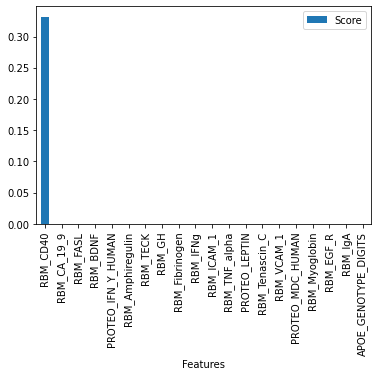

In [123]:
mw_df.plot.bar(x='Features',y='Score')
plt.savefig("/content/drive/MyDrive/d2k/1_MannWhitney2.pdf", format="pdf", bbox_inches="tight")
plt.show()

<Figure size 432x288 with 0 Axes>

> **CHI SQUARE TEST**

In [124]:
df3=df2
df3[df3<0]=99 #Chi square doesn't recognize negative values- missing values aka -9 are resubstituted as 99

In [125]:
X = df3.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df3['P1_PT_TYPE']
chi=chi2(X,y)   #returns f score and p value 

#Chi Test Score
chi_score=chi[1].tolist()

# #Chi Test Features
chi_features=list(X)

chi_dict = {'Features':chi_features,'Score':chi_score}
chi_df=pd.DataFrame(chi_dict)
chi_df=chi_df.sort_values(by='Score', ascending=False)
chi_df=chi_df.head(30)

chi_df

,Features,Score
186,P1_BGRESULT,1.000000
177,RBM_TF,0.990582
74,RBM_APO_A1,0.988928
144,RBM_MIF,0.988086
91,RBM_Complement_3,0.984948
156,RBM_PAP,0.973111
107,RBM_Fibrinogen,0.972786
165,RBM_Sortilin,0.972656
134,RBM_IL_3,0.960814
128,RBM_IL_12p40,0.957763


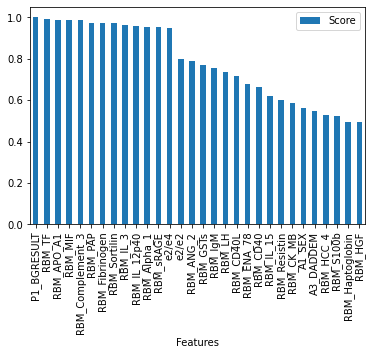

In [126]:
chi_df.plot.bar(x='Features',y='Score')
plt.savefig("/content/drive/MyDrive/d2k/2_ChiSquare2.pdf", format="pdf", bbox_inches="tight")
plt.show()

> **MUTUAL INFORMATION TEST**

In [127]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']
mi= MIC(X,y)

#Mutual Info Features
mi_cols=list(X.columns)

#Mutual Info Scores
mi_score=mi.tolist()


mi_dict = {'Features':mi_cols,'Score':mi_score}
mi_df=pd.DataFrame(mi_dict)
mi_df=mi_df.sort_values(by='Score', ascending=False)
mi_df=mi_df.head(30)


mi_df

,Features,Score
4,APOE_GENOTYPE_DIGITS,0.291158
7,APOE_E4_COUNT,0.282613
6,APOE_E3_COUNT,0.263148
5,APOE_E2_COUNT,0.257709
107,RBM_Fibrinogen,0.150272
121,RBM_IFNg,0.150047
180,RBM_TNF_beta,0.149658
171,RBM_THPO,0.132579
179,RBM_TNF_alpha,0.128513
127,RBM_IL_10,0.111954


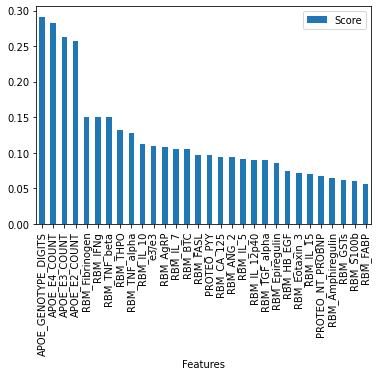

In [128]:
mi_df.plot.bar(x='Features',y='Score')
plt.savefig("/content/drive/MyDrive/d2k/3_MutualInfo2.pdf", format="pdf", bbox_inches="tight")
plt.show()

*EMBEDDED FEATURE SELECTION*

> **RANDOM FOREST BASED FEATURE SELECTION**

In [129]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

#Standard Scaling
sc=StandardScaler()
sc.fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

Xcols=list(X.columns)
X_train_std=pd.DataFrame(X_train_std, columns=Xcols)
X_test_std=pd.DataFrame(X_test_std, columns=Xcols)

#Fitting the model
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train_std, y_train.values.ravel())

#RF Score
rf_score=forest.feature_importances_.tolist()

#RF Features
rf_features=list(X.columns)

rf_dict = {'Features':rf_features,'Score':rf_score}
rf_df=pd.DataFrame(rf_dict)
rf_df=rf_df.sort_values(by='Score', ascending=False)
rf_df=rf_df.head(30)

rf_df

,Features,Score
4,APOE_GENOTYPE_DIGITS,0.091813
6,APOE_E3_COUNT,0.068761
7,APOE_E4_COUNT,0.049283
5,APOE_E2_COUNT,0.047609
171,RBM_THPO,0.025831
190,e3/e3,0.022435
0,AGE,0.015673
100,RBM_Eotaxin_3,0.014458
137,RBM_IL_8,0.014335
168,RBM_Tenascin_C,0.011138


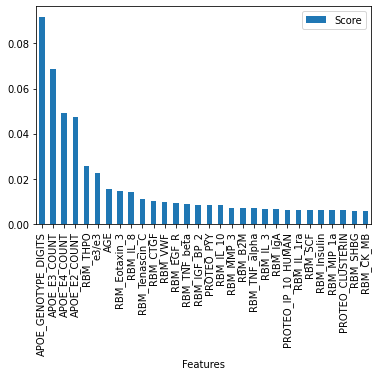

In [130]:
rf_df.plot.bar(x='Features',y='Score')
plt.savefig("/content/drive/MyDrive/d2k/4_RandomForest2.pdf", format="pdf", bbox_inches="tight")
plt.show()

*WRAPPER BASED FEATURE SELECTION*

**RECURSIVE FEATURE SELECTION**
Using Random Forest

In [131]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=30)
rfs=rfe.fit(X, y)

#RFS Features
rfs_features= list(X.columns)

#RFS Scores
rfs_score= rfs.support_.tolist()

rfs_dict = {'Features':rfs_features,'Score':rfs_score}


In [132]:
rfs_df= pd.DataFrame.from_dict(rfs_dict)
rfs_df=rfs_df.loc[rfs_df['Score'] == True]
rfs_df

,Features,Score
0,AGE,True
4,APOE_GENOTYPE_DIGITS,True
5,APOE_E2_COUNT,True
6,APOE_E3_COUNT,True
7,APOE_E4_COUNT,True
10,B1_BPSYS,True
51,PROTEO_PYY,True
67,RBM_AgRP,True
84,RBM_CRP,True
92,RBM_Cortisol,True


**RECURSIVE FEATURE SELECTION**
Using Decision Tree

In [133]:
rfe2 = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=30)
rfs2 = rfe2.fit(X, y)

#RFS Features
rfs2_features= list(X.columns)

#RFS Scores
rfs2_score= rfs2.support_.tolist()

rfs2_dict = {'Features':rfs2_features,'Score':rfs2_score}

In [134]:
rfs2_df= pd.DataFrame.from_dict(rfs2_dict)
rfs2_df=rfs2_df.loc[rfs2_df['Score'] == True]
rfs2_df

,Features,Score
0,AGE,True
4,APOE_GENOTYPE_DIGITS,True
6,APOE_E3_COUNT,True
7,APOE_E4_COUNT,True
8,B1_BMI,True
12,PROTEO_BFGF,True
52,PROTEO_RESISTIN,True
53,PROTEO_SAA,True
70,RBM_Alpga_F,True
83,RBM_BDNF,True


> **FORWARD FEATURES SELECTION**: Using Decision Tree Classifier



In [135]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']

model = DecisionTreeClassifier()
ff1 = sfs(model, k_features=30, forward=True, verbose=2, scoring='accuracy')
ff1 = ff1.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    1.5s finished

[2022-10-24 03:56:20] Features: 1/30 -- score: 0.823529411764706[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    1.5s finished

[2022-10-24 03:56:21] Features: 2/30 -- score: 0.8470588235294118[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    1.5s finished

[2022-10-24 03:56:23] Features: 3/30 -- score: 0.8470588235294118[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [136]:
ff1.subsets_

{1: {'feature_idx': (4,),
  'cv_scores': array([0.88235294, 0.88235294, 0.78991597, 0.67226891, 0.8907563 ]),
  'avg_score': 0.823529411764706,
  'feature_names': ('APOE_GENOTYPE_DIGITS',)},
 2: {'feature_idx': (4, 180),
  'cv_scores': array([0.85714286, 0.8487395 , 0.89915966, 0.7394958 , 0.8907563 ]),
  'avg_score': 0.8470588235294118,
  'feature_names': ('APOE_GENOTYPE_DIGITS', 'RBM_TNF_beta')},
 3: {'feature_idx': (4, 5, 180),
  'cv_scores': array([0.85714286, 0.8487395 , 0.89915966, 0.7394958 , 0.8907563 ]),
  'avg_score': 0.8470588235294118,
  'feature_names': ('APOE_GENOTYPE_DIGITS', 'APOE_E2_COUNT', 'RBM_TNF_beta')},
 4: {'feature_idx': (4, 5, 180, 186),
  'cv_scores': array([0.85714286, 0.8487395 , 0.89915966, 0.7394958 , 0.8907563 ]),
  'avg_score': 0.8470588235294118,
  'feature_names': ('APOE_GENOTYPE_DIGITS',
   'APOE_E2_COUNT',
   'RBM_TNF_beta',
   'P1_BGRESULT')},
 5: {'feature_idx': (4, 5, 180, 186, 187),
  'cv_scores': array([0.85714286, 0.8487395 , 0.89915966, 0.7394

In [137]:
ff1_dict=ff1.get_metric_dict(confidence_interval=0.8)
ff1_df = pd.DataFrame.from_dict(ff1_dict).T
ff1_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.8823529411764706, 0.8823529411764706, 0.789...",0.823529,"(APOE_GENOTYPE_DIGITS,)",0.062136,0.084202,0.042101
2,"(4, 180)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.847059,"(APOE_GENOTYPE_DIGITS, RBM_TNF_beta)",0.042132,0.057093,0.028547
3,"(4, 5, 180)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.847059,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, RBM_TNF_...",0.042132,0.057093,0.028547
4,"(4, 5, 180, 186)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.847059,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, RBM_TNF_...",0.042132,0.057093,0.028547
5,"(4, 5, 180, 186, 187)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.847059,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, RBM_TNF_...",0.042132,0.057093,0.028547
6,"(4, 5, 180, 186, 187, 191)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.847059,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, RBM_TNF_...",0.042132,0.057093,0.028547
7,"(4, 5, 180, 186, 187, 191, 192)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.847059,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, RBM_TNF_...",0.042132,0.057093,0.028547
8,"(4, 5, 180, 186, 187, 188, 191, 192)","[0.8571428571428571, 0.8487394957983193, 0.890...",0.845378,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, RBM_TNF_...",0.041059,0.05564,0.02782
9,"(4, 5, 7, 180, 186, 187, 188, 191, 192)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.843697,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, APOE_E4_...",0.046834,0.063466,0.031733
10,"(4, 5, 6, 7, 180, 186, 187, 188, 191, 192)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.843697,"(APOE_GENOTYPE_DIGITS, APOE_E2_COUNT, APOE_E3_...",0.046834,0.063466,0.031733


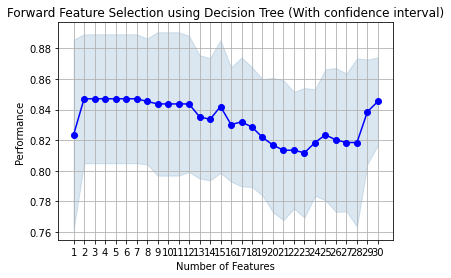

In [138]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1=plot_sfs(ff1_dict, kind='ci')
plt.title('Forward Feature Selection using Decision Tree (With confidence interval)')
plt.savefig("/content/drive/MyDrive/d2k/5_ForwardFeature.pdf2", format="pdf", bbox_inches="tight")
plt.grid()
plt.show()

In [139]:
ff1_features=list(ff1_df['feature_names'][30])
ff1_features

['A1_SEX',
 'A3_DADDEM',
 'A3_MOMDEM',
 'APOE_GENOTYPE_DIGITS',
 'APOE_E2_COUNT',
 'APOE_E3_COUNT',
 'APOE_E4_COUNT',
 'PROTEO_EOTAXIN_3_HUMAN',
 'PROTEO_IL_13_HUMAN',
 'PROTEO_IL_1A',
 'PROTEO_IL_2_HUMAN',
 'PROTEO_PYY',
 'RBM_Amphiregulin',
 'RBM_Epiregulin',
 'RBM_Galanin',
 'RBM_IL_12p40',
 'RBM_IL_3',
 'RBM_LH',
 'RBM_Myoglobin',
 'RBM_OSM',
 'RBM_TGF_alpha',
 'RBM_THPO',
 'RBM_TNF_beta',
 'P1_BGRESULT',
 'e2/e2',
 'e2/e3',
 'e2/e4',
 'e3/e3',
 'e3/e4',
 'e4/e4']

> **FORWARD FEATURE SELECTION**: Using Random Forest

In [140]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']

model = RandomForestClassifier()
ff2 = sfs(model, k_features=30, forward=True, verbose=2, scoring='accuracy')
ff2 = ff2.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:  2.3min finished

[2022-10-24 04:01:32] Features: 1/30 -- score: 0.823529411764706[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  2.1min finished

[2022-10-24 04:03:38] Features: 2/30 -- score: 0.8420168067226891[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:  2.1min finished

[2022-10-24 04:05:46] Features: 3/30 -- score: 0.8436974789915966[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [141]:
ff2_dict=ff2.get_metric_dict(confidence_interval=0.8)
ff2_df = pd.DataFrame.from_dict(ff2_dict).T
ff2_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.8823529411764706, 0.8823529411764706, 0.789...",0.823529,"(APOE_GENOTYPE_DIGITS,)",0.062136,0.084202,0.042101
2,"(4, 180)","[0.8571428571428571, 0.8487394957983193, 0.899...",0.842017,"(APOE_GENOTYPE_DIGITS, RBM_TNF_beta)",0.049205,0.066678,0.033339
3,"(2, 4, 180)","[0.8571428571428571, 0.8319327731092437, 0.899...",0.843697,"(A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_TNF_beta)",0.04235,0.057389,0.028695
4,"(2, 4, 180, 188)","[0.8571428571428571, 0.8487394957983193, 0.890...",0.845378,"(A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_TNF_beta...",0.041059,0.05564,0.02782
5,"(2, 4, 180, 188, 189)","[0.8571428571428571, 0.8403361344537815, 0.899...",0.845378,"(A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_TNF_beta...",0.042168,0.057143,0.028571
6,"(2, 4, 128, 180, 188, 189)","[0.8403361344537815, 0.8487394957983193, 0.873...",0.843697,"(A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_IL_12p40...",0.032007,0.043373,0.021687
7,"(2, 4, 128, 180, 186, 188, 189)","[0.8403361344537815, 0.8487394957983193, 0.882...",0.842017,"(A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_IL_12p40...",0.030732,0.041645,0.020823
8,"(0, 2, 4, 128, 180, 186, 188, 189)","[0.7815126050420168, 0.8571428571428571, 0.857...",0.840336,"(AGE, A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_IL_...",0.025718,0.034851,0.017426
9,"(0, 2, 4, 73, 128, 180, 186, 188, 189)","[0.8235294117647058, 0.8907563025210085, 0.865...",0.848739,"(AGE, A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_Ang...",0.027172,0.036822,0.018411
10,"(0, 2, 4, 73, 126, 128, 180, 186, 188, 189)","[0.8235294117647058, 0.8823529411764706, 0.865...",0.853782,"(AGE, A3_DADDEM, APOE_GENOTYPE_DIGITS, RBM_Ang...",0.027621,0.03743,0.018715


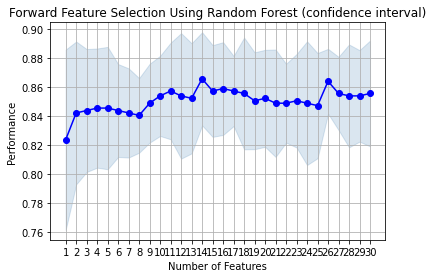

In [142]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig2=plot_sfs(ff2_dict, kind='ci')
plt.title('Forward Feature Selection Using Random Forest (confidence interval)')
plt.grid()
plt.show()

In [144]:
ff1_features=list(ff1_df['feature_names'][30])
ff1_features

['A1_SEX',
 'A3_DADDEM',
 'A3_MOMDEM',
 'APOE_GENOTYPE_DIGITS',
 'APOE_E2_COUNT',
 'APOE_E3_COUNT',
 'APOE_E4_COUNT',
 'PROTEO_EOTAXIN_3_HUMAN',
 'PROTEO_IL_13_HUMAN',
 'PROTEO_IL_1A',
 'PROTEO_IL_2_HUMAN',
 'PROTEO_PYY',
 'RBM_Amphiregulin',
 'RBM_Epiregulin',
 'RBM_Galanin',
 'RBM_IL_12p40',
 'RBM_IL_3',
 'RBM_LH',
 'RBM_Myoglobin',
 'RBM_OSM',
 'RBM_TGF_alpha',
 'RBM_THPO',
 'RBM_TNF_beta',
 'P1_BGRESULT',
 'e2/e2',
 'e2/e3',
 'e2/e4',
 'e3/e3',
 'e3/e4',
 'e4/e4']

> **BACKWARDS FEATURES ELIMINATION**: 
Using Log Reg

In [ ]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']

bf1 = sfs(LogisticRegression(), k_features=30, forward=False, verbose=1, scoring='accuracy')
bf1 = bf1.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
bf1_dict=bf1.get_metric_dict(confidence_interval=0.8)
bf1_df = pd.DataFrame.from_dict(bf1_dict).T
bf1_df

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1=plot_sfs(bf1_dict, kind='ci')
plt.title('Backward Feature Selection using Log Regression (With confidence interval)')
plt.grid()
plt.show()

In [ ]:
bf1_features=list(bf1_df['feature_names'][30])
bf1_features

> **BACKWARDS FEATURES ELIMINATION**: Using Decision Tree Classifer

In [ ]:
X = df2.drop(['P1_PT_TYPE'], axis=1, inplace = False)
y = df2['P1_PT_TYPE']

model = DecisionTreeClassifier()
bf2 = sfs(model, k_features=30, forward=False, verbose=1, scoring='accuracy')
bf2 = bf2.fit(X,y)

In [ ]:
bf2_dict=bf2.get_metric_dict(confidence_interval=0.8)
bf2_df = pd.DataFrame.from_dict(bf2_dict).T
bf2_df

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1=plot_sfs(bf2_dict, kind='ci')
plt.title('Backward Feature Selection using Random Forest Classifier (With confidence interval)')
plt.grid()
plt.show()

In [ ]:
bf2_features=list(bf2_df['feature_names'][30])
bf2_features

*OTHER METHODS*


> **BORUTA** Using Random Forest, provides a rank

In [145]:
model = RandomForestRegressor(n_estimators=100, max_depth=5)
# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

# train Boruta
# N.B.: X and y must be numpy arrays
feat_selector.fit(np.array(X), np.array(y))

# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print(X.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])


Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	193
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	193
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	193
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	193
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	193
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	193
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	193
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	0
Tentative: 	15
Rejected: 	178
Iteration: 	9 / 10
Confirmed: 	4
Tentative: 	11
Rejected: 	178


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	3
Rejected: 	178

------Support and Ranking for each feature------
AGE  - Ranking:  1
APOE_GENOTYPE_DIGITS  - Ranking:  1
APOE_E4_COUNT  - Ranking:  1
RBM_IL_3  - Ranking:  1


In [146]:
boruta_features=[]
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        boruta_features.append(X.columns[i])
boruta_features

['AGE', 'APOE_GENOTYPE_DIGITS', 'APOE_E4_COUNT', 'RBM_IL_3']

> **KENDALL'S TAU CORRELATION**

In [147]:
# Data Visualisation Settings
from pylab import rcParams 
%matplotlib inline
rcParams['figure.figsize'] = 5,4
sns.set_style('whitegrid')

In [148]:
corr = df2.corr(method='kendall')

In [ ]:
rcParams['figure.figsize'] = 14.7,8.27
sns.heatmap(corr, 
           xticklabels=corr.columns.values, 
           yticklabels=corr.columns.values, 
           cmap="YlGnBu",
          annot=True)

> **KRUSKAL WALLIS TEST**

In [151]:
from pyparsing import printables

kruskal_features = []
kruskal_scores = []

for col in X.columns:
    feature = X[col]

    result = stats.kruskal(list(feature), list(y))
    # reject null hypothesis if p <= p_value, else fail to reject null hypothesis and accept the column
    if result.pvalue > 0:
        kruskal_features.append(col)
        kruskal_scores.append(result.pvalue)
# print(kruskal_features, kruskal_scores)

In [161]:
kruskal_features= pd.DataFrame(kruskal_features)
kruskal_scores= pd.DataFrame(kruskal_scores)
kruskal_df= pd.concat([kruskal_features, kruskal_scores], axis=1)
kruskal_df.columns = ['Features', 'Score']
kruskal_df = kruskal_df.sort_values(by='Score', ascending=False)
kruskal_df.iloc[:30, :]

,Features,Score
32,PROTEO_IL_2_HUMAN,8.723923e-01
89,RBM_CD40L,3.314875e-01
23,PROTEO_IL_10_HUMAN,9.150479e-02
87,RBM_CEA,3.341938e-04
105,RBM_FABP,2.940407e-04
59,PROTEO_TNF_B,2.173154e-05
84,RBM_CRP,4.195076e-06
72,RBM_ANG_2,2.359907e-07
7,APOE_E4_COUNT,5.849418e-08
174,RBM_TSH,4.066731e-09


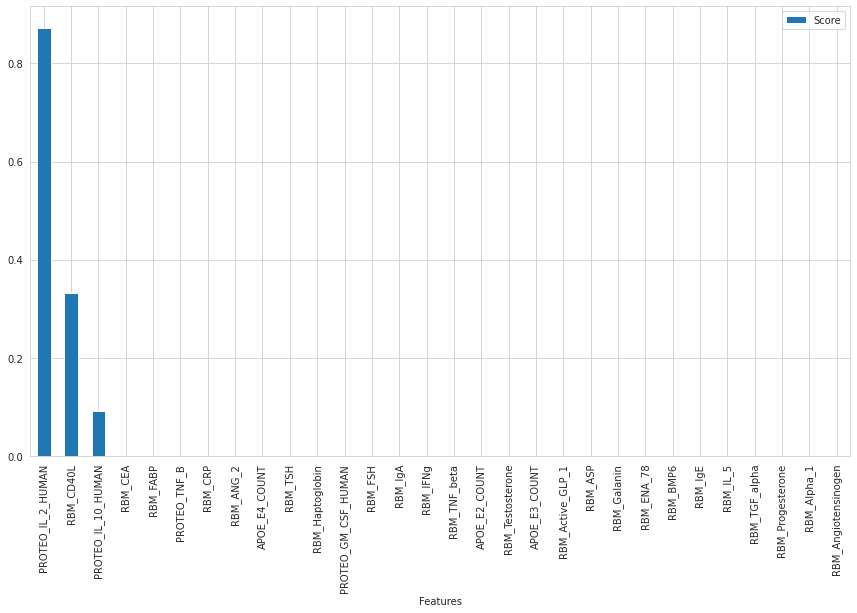

In [162]:
kruskal_df.iloc[:30,:].plot.bar(x='Features',y='Score')
plt.savefig("/content/drive/MyDrive/d2k/6_Kruskal.pdf", format="pdf", bbox_inches="tight")
plt.show()

>**_COMBINING ALL THE FEATURES FROM ALL THE FEATURE IMPORTANCE METHODS_**

In [163]:
features=[]
features=list(mw_df['Features'])+list(mi_df['Features'])+list(chi_df['Features'])+list(rf_df['Features'])+list(rfs_df['Features'])+list(rfs2_df['Features'])+ff1_features+boruta_features+list(kruskal_df['Features'])
features=pd.DataFrame(features).reset_index(drop=True)
features.columns = ['Features']
counts = features['Features'].value_counts().to_frame().reset_index()
counts.columns=['Features','Frequency']
counts=counts.head(28)
x=list(counts['Features'])
x


['APOE_GENOTYPE_DIGITS',
 'APOE_E4_COUNT',
 'RBM_IL_3',
 'RBM_TNF_beta',
 'APOE_E3_COUNT',
 'RBM_THPO',
 'RBM_Tenascin_C',
 'APOE_E2_COUNT',
 'e3/e3',
 'PROTEO_PYY',
 'AGE',
 'RBM_EGF_R',
 'RBM_Myoglobin',
 'RBM_GSTs',
 'RBM_IL_10',
 'RBM_TNF_alpha',
 'RBM_Fibrinogen',
 'RBM_IL_8',
 'RBM_Amphiregulin',
 'RBM_MIP_1a',
 'RBM_Eotaxin_3',
 'RBM_IL_12p40',
 'RBM_S100b',
 'RBM_IL_15',
 'RBM_CD40',
 'P1_BGRESULT',
 'RBM_Epiregulin',
 'RBM_Prolactin']

**PICKLING**

Pickling is done in order to store the results of the feature selection. This circumvents the necessity to rerun feature selection repeatedly. The pickled features can be unpickled for modeling purpose.

In [164]:
import pickle

with open("/content/drive/MyDrive/d2k/features2", "wb") as fp:
  pickle.dump(x, fp)
X_feat = pickle.load(open("/content/drive/MyDrive/d2k/features2", "rb" ))
X_feat

['APOE_GENOTYPE_DIGITS',
 'APOE_E4_COUNT',
 'RBM_IL_3',
 'RBM_TNF_beta',
 'APOE_E3_COUNT',
 'RBM_THPO',
 'RBM_Tenascin_C',
 'APOE_E2_COUNT',
 'e3/e3',
 'PROTEO_PYY',
 'AGE',
 'RBM_EGF_R',
 'RBM_Myoglobin',
 'RBM_GSTs',
 'RBM_IL_10',
 'RBM_TNF_alpha',
 'RBM_Fibrinogen',
 'RBM_IL_8',
 'RBM_Amphiregulin',
 'RBM_MIP_1a',
 'RBM_Eotaxin_3',
 'RBM_IL_12p40',
 'RBM_S100b',
 'RBM_IL_15',
 'RBM_CD40',
 'P1_BGRESULT',
 'RBM_Epiregulin',
 'RBM_Prolactin']

**MODELING**

The following models will be considered.
1. XGBoost with Random Forest
2. Log Regression
3. 

**YET TO SORT OUT BELOW**

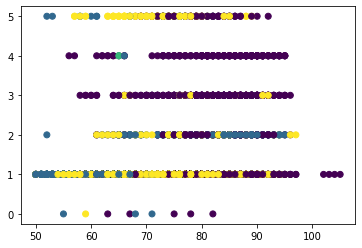

In [ ]:

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)

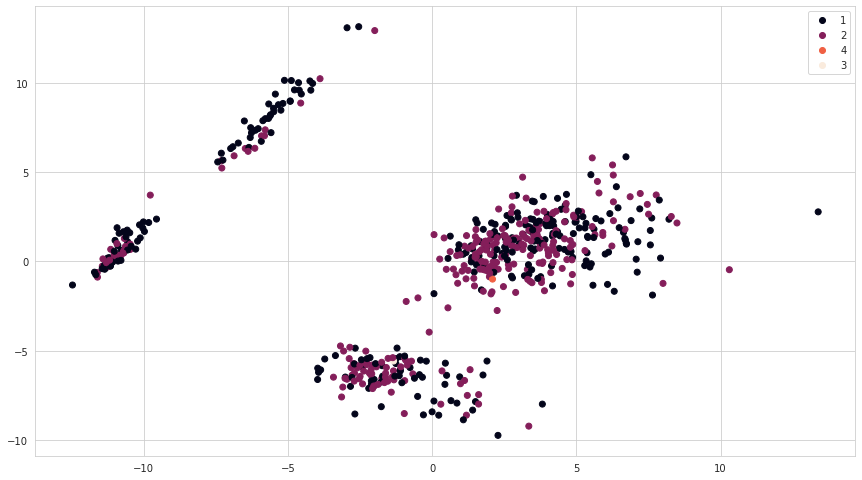

In [167]:

# kpca = KernelPCA(kernel="rbf", n_components=2, gamma=.01)
# z = kpca.fit_transform(X)
# df = pd.DataFrame()
# df["y"] = y
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]

# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 palette=sns.color_palette("hls", 4),
#                 data=df).set(title="Biomarkers KernelPCA projection")
pca = PCA(.95)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
# print(Xt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [ ]:
# sns.heatmap(df2.loc[:,['A41_PMAP', 'A41_PMAPREV', 'A41_PMBP', 'A41_PMBPF', 'A41_PMBPREV', 
#         'A43_ADCCONT', 'A43_ADCPREV', 'A43_ADDCONT', 'A43_ADDPREV', 'A43_ADECONT', 
#         'A43_ADEPREV', 'A43_ADFCONT', 'A5_ABUSOTHR', 'A5_CVBYPASS', 'A5_CVCHF', 
#         'A5_IBD', 'B5_ELAT', 'C1_CDRSUM', 'C1_SS_WAISR_DIGTOT', 'C1_WAISR_DIGIF', 
#        'C1_WAISR_DIGILF', 'C1_WMS3_STORY1B1', 'C1_WMSR_STORY2B', 'D1_ALCDEM', 
#        'D1_BRNINJ', 'D1_DEMENTED', 'D1_HUNT', 'D1_NORMCOG', 'X1_CHF_SR', 'X1_SMOKE_EVER','P1_PT_TYPE']].corr())
# sns.set(rc={'figure.figsize':(20,20)})